In [1]:
#Classical libraries
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl
import pandas as pd

#Machine learning modules
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, validation_curve
from sklearn import preprocessing

#Statistics libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
#stud_var is a string ('')
def anova(names, stud_var):
    stud_var += ' ~'
    for i in range(len(names)):
        stud_var+= ' + ' + 'C(' + names[i] + ')'
    print(stud_var)
    model = ols(stud_var, df).fit()
    model.summary()
    res = sm.stats.anova_lm(model, typ= 1)   # Need type 1 to agree with paper and with Matlab
    print(res)
    objects=names
    objects=tuple(objects)
    y_pos = np.arange(len(objects))  # this just makes an array [0, 1, 2, 3]
                                     # arrange makes evenly spaced values on a 
                                     # given interval.  Sort of expects integers

    totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing

    performance = []
    for i in range(len(objects)):
        performance+=[res.sum_sq[i]/totalSSRnoRes]

    plt.figure()                   # can number them but they will not overwrite unless you close them

    if len(objects)==3:
        colour=['skyblue', 'peru', 'yellowgreen']
    elif len(objects)==2:
        colour=['skyblue', 'peru']
    elif len(objects)==4:
        colour=['skyblue', 'peru', 'yellowgreen', 'gold']
    elif len(objects)==5:
        colour=['skyblue', 'peru', 'yellowgreen', 'gold', 'pink']

    plt.bar(y_pos, performance, 
            align='center', 
            width=0.8,              # default is 0.8
            alpha=1.0,              # this is transparency, 1.0 is solid
            color=colour)
    plt.xticks(y_pos, objects)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    font = {'size': 18}
    plt.xlabel('Conditions', font)
    plt.ylabel('Fraction of total variance', font)
    plt.title('Anova', font)

    print(performance)
    plt.show()

In [3]:
#define df et names before hand
#stud_var is a string ('')
#size is an array [] giving the range of the obtained results
def pred_fit(stud_var, size):

#Optimistion of C:
    variable = df.loc[:, names]
    target = df[stud_var]
    param_range = np.linspace(2,200,50)   # set the range for parameter C
    train_loss, test_loss = validation_curve(
            svm.SVR(kernel='rbf', gamma=0.5), 
            preprocessing.scale(variable), preprocessing.scale(target.values.ravel()), param_name='C',
            param_range=param_range, cv=10, 
            scoring = 'neg_mean_squared_error')
    train_loss_mean = -np.mean(train_loss, axis=1)
    test_loss_mean = -np.mean(test_loss, axis=1)
    plt.figure(1)
    plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
    plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    font = {'size': 22}
    plt.xlabel("C", font)
    plt.ylabel("Loss", font)
    plt.legend(loc="best", fontsize=22)
    plt.show()
    label=[]
    verif=[]
    for i in range(len(param_range)):    
        label+=[[test_loss_mean[i], param_range[i]]]
        verif+=[[train_loss_mean[i], param_range[i]]]
    C=min(label)[1]
    a=label.index(min(label))
    if C<100:
        C=100

#Optimistion of gamma:
    param_range = np.linspace(0,1,50) # set the range for parameter gamma
    train_loss, test_loss = validation_curve(
             svm.SVR(kernel='rbf', C=C),
             preprocessing.scale(variable), preprocessing.scale(target.values.ravel()),
             param_name='gamma',
             param_range=param_range, cv=10,
             scoring = 'neg_mean_squared_error')
    train_loss_mean = -np.mean(train_loss, axis=1)
    test_loss_mean = -np.mean(test_loss, axis=1)
    label=[]
    for i in range(len(param_range)):    
        label+=[[test_loss_mean[i], param_range[i]]]
    gamma=min(label)[1]
    a=label.index(min(label))
    if a<len(label)-1:
        if label[a][0] < label[a+1][0]-0.1:
            del label[a]
        gamma=min(label)[0]
    if gamma==0:
        gamma=0.1
    plt.figure(2)
    plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
    plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    font = {'size': 22}
    plt.xlabel("gamma", font)
    plt.ylabel("Loss", font)
    plt.legend(loc="best", fontsize=22)
    plt.show()

#optimisation of epsilon
    param_range = np.linspace(0,1,50) # set the range for parameter gamma
    train_loss, test_loss = validation_curve(
         svm.SVR(kernel='rbf', C=C, gamma=gamma),
         preprocessing.scale(variable), preprocessing.scale(target.values.ravel()),
         param_name='epsilon',
         param_range=param_range, cv=10,
         scoring = 'neg_mean_squared_error')
    train_loss_mean = -np.mean(train_loss, axis=1)
    test_loss_mean = -np.mean(test_loss, axis=1)
    label=[]
    verif=[]
    epsilon=0
    for i in range(len(param_range)):    
        label+=[[test_loss_mean[i], param_range[i]]]
        verif+=[[train_loss_mean[i], param_range[i]]]
        if verif[i][0]>0.0001 and verif[i-1][0]<0.0001:
            epsilon=verif[i][1]
    plt.figure(3)
    plt.plot(param_range, train_loss_mean, 'o-', color="r", label="Training")
    plt.plot(param_range, test_loss_mean, 'o-', color="g", label="Cross_validation")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    font = {'size':15}
    plt.xlabel("epsilon")
    plt.ylabel("Loss")
    plt.legend(loc="best",fontsize=15)
    plt.show()

#fitting function creation:
    reg_stud_var = Pipeline(steps = [('scl', StandardScaler()), ('clf', svm.SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon))])
    reg_stud_var.fit(variable, target) #fit the fundtion to the values.
    calc_var= stud_var + '_pred_svm'
    df[calc_var] = reg_stud_var.predict(variable) # crée une colonne dans le tableau avec les nouvelles valeurs prédites

#graph plotting:
    fig, ax1 = plt.subplots(1, 1, clear=True, num='PCE_pred', figsize=(5, 4))
    for label, data in df.groupby('exp'):
        plt.plot(stud_var, calc_var,'o', color=data['color'].iloc[0], data=data, label=label)
       # plt.legend()
    plt.autoscale(enable=True)
    plt.plot(size, size, ls="--", c=".3") #Trace la courbe x=y. Adapter les valeurs dans les [] aux valeurs utilisées.
    ylabel = 'Predicted ' + stud_var + ' (%)'
    xlabel = 'Mesured ' + stud_var + ' (%)'
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    plt.tight_layout()

#Linear regration and r2 calculation
    X=df[[stud_var]]
    y=df[[calc_var]]
    modeleReg=LinearRegression()
    modeleReg.fit(X, y)
    modeleReg.score(X,y)
    r2=modeleReg.score(X,y)
    plt.show()
    print('R2 =', r2)
    print('C=', C)
    print('gamma=', gamma)
    print('epsilon=', epsilon)
    return reg_stud_var

In [4]:
#df, names, data_v and data_u to be defined before hand.
#fonc is the fitting function optimised in the previous program.
def surface_plot(fonc, xmin, xmax, ymin, ymax, vmin, vmax, colour):
    ## Optimisation of 2 parameters
    if len(names)==2:
        x_len, y_len = 100, 100
        xs = np.linspace(xmin, xmax, x_len)
        ys = np.linspace(ymin, ymax, y_len)
        xi, yi = names[0], names[1]
        fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, clear=True, num='rbf pce plot', figsize=(10, 10))
        xm, ym = np.meshgrid(xs,ys)
        r = np.c_[xm.flatten(), ym.flatten()]
    #compute the values from the fit
        c = fonc.predict(r).reshape(x_len, y_len)

	#Make a contour map
        cmap = axs.contour(xs, ys, c, vmin=vmin, vmax=vmax, cmap='gray_r')
        plt.clabel(cmap, inline=1, fontsize=10)
	# Make a value map
        pmap = axs.pcolormesh(xs, ys, c, shading='gouraud', vmin=vmin,	vmax=vmax, cmap=colour)
        for label,data in df.groupby('exp'):
            axs.plot(names[0], names[1],'o',color=data['color'].iloc[0], data=data.iloc[0], mec='k', mew=0.5, label=label)
        axs.set_ylabel(f'{yi}')
        axs.set_xlabel(f'{xi}')
    
    ## Optimisation of 3 parameters
    if len(names)==3:
        v_len = len(data_v)
        vs = data_v
        x_len, y_len = 100, 100
        xs = np.linspace(xmin, xmax, x_len)
        ys = np.linspace(ymin, ymax, y_len)
        vi, xi, yi = names[0], names[1], names[2]
        fig, axs = plt.subplots(nrows=1, ncols=v_len, sharex=True, sharey=True, clear=True, num='rbf pce plot', figsize=(13, 4))
        for ax, v in zip(axs, vs):
            xm, ym = np.meshgrid(xs,ys)
            vm = v * np.ones_like(xm)
            r = np.c_[vm.flatten(), xm.flatten(), ym.flatten()]
    
	#compute the values from the fit
            c = fonc.predict(r).reshape(x_len, y_len)

	#Make a contour map
            cmap = ax.contour(xs, ys, c, vmin=vmin, vmax=vmax, cmap='gray_r')
            plt.clabel(cmap, inline=1, fontsize=10)
	# Make a value map
            pmap = ax.pcolormesh(xs, ys, c, shading='gouraud', vmin=vmin,	vmax=vmax, cmap=colour)
	# Plot the experimental points
            for label,data in df.query(vi + ' ==@v').groupby('exp'):
                ax.plot(names[1], names[2],'o',color=data['color'].iloc[0], data=data.iloc[0], mec='k', mew=0.5, label=label)
            ax.set_ylabel(f'{yi}')
            ax.set_xlabel(f'{xi} @ {vi} ={v:.2f}')
    
    ## Optimisation of 4 parameters
    elif len(names)==4:
        v_len = len(data_v)
        u_len= len(data_u)
        vs = data_v
        us = data_u
        x_len, y_len = 100, 100
        xs = np.linspace(xmin, xmax, x_len)
        ys = np.linspace(ymin, ymax, y_len)
        xi, yi, ui, vi = names[0], names[1], names[2], names[3]
        fig, axs = plt.subplots(nrows=u_len, ncols=v_len, sharex=True, sharey=True, clear=True, num='rbf pce plot', figsize=(13, 4*u_len))
        for u, i in zip(us, range(u_len)):    
            for ax, v in zip(axs[i], vs):
                xm, ym = np.meshgrid(xs,ys)
                vm = v * np.ones_like(xm)
                um = u * np.ones_like(xm)
                r = np.c_[xm.flatten(), ym.flatten(), um.flatten(), vm.flatten()]
	#compute the values from the fit
                c = fonc.predict(r).reshape(x_len, y_len)

	#Make a contour map
                cmap = ax.contour(xs, ys, c, vmin=vmin, vmax=vmax, cmap='gray_r')
                plt.clabel(cmap, inline=1, fontsize=10)
	# Make a value map
                pmap = ax.pcolormesh(xs, ys, c, shading='gouraud', vmin=vmin,	vmax=vmax, cmap=colour)
	# Plot the experimental points
                for label,data in df.query(vi + ' ==@v' + ' and ' + ui + '==@u').groupby('exp'):
                    ax.plot(names[0],names[1],'o',color=data['color'].iloc[0], data=data.iloc[0], mec='k', mew=0.5, label=label)
                ax.set_ylabel(f'[{yi}] // [{ui}]={u:.2f}')
                ax.set_xlabel(f'[{xi}] // [{vi}] ={v:.2f}')
    #ax.plot(0.215, 0.44,'o',color='black', mec='k', mew=0.5, label=label)
    plt.tight_layout()
    plt.colorbar(pmap, ax=axs, fraction=0.01)
    plt.show()

In [5]:
##Same function without the experimental points to allow a zoom

#df, names, data_v and data_u to be defined before hand.
#fonc is the fitting function optimised in the previous program.
def surface_plot2(fonc, xmin, xmax, ymin, ymax, vmin, vmax, colour):
        
    if len(names)==3:
        v_len = len(data_v)
        vs = data_v
        x_len, y_len = 100, 100
        xs = np.linspace(xmin, xmax, x_len)
        ys = np.linspace(ymin, ymax, y_len)
        vi, xi, yi = names[0], names[1], names[2]
        fig, axs = plt.subplots(nrows=1, ncols=v_len, sharex=True, sharey=True, clear=True, num='rbf pce plot', figsize=(13, 4))
        for ax, v in zip(axs, vs):
            xm, ym = np.meshgrid(xs,ys)
            vm = v * np.ones_like(xm)
            r = np.c_[vm.flatten(), xm.flatten(), ym.flatten()]
    
	#compute the values from the fit
            c = fonc.predict(r).reshape(x_len, y_len)

	#Make a contour map
            cmap = ax.contour(xs, ys, c, vmin=vmin, vmax=vmax, cmap='gray_r')
            plt.clabel(cmap, inline=1, fontsize=10)
	# Make a value map
            pmap = ax.pcolormesh(xs, ys, c, shading='gouraud', vmin=vmin,	vmax=vmax, cmap=colour)
	# Plot the experimental points
            ax.set_ylabel(f'[{yi}]')
            ax.set_xlabel(f'[{xi}] @ [{vi}] ={v:.2f}')
            
    plt.tight_layout()
    plt.colorbar(pmap, ax=axs, fraction=0.01)
    plt.show()

In [12]:
df = pd.read_csv("Iode-1.csv", sep=';') #CSV table in the same folder as the programme!
##deleting NaNs: if df contains NaN cells when displayed, the first line below can be used to
#delete rows with less than 'x' non-NaN values (change according to the table obtained) 
#2 deletes columns containing at least one NaN.
#df = df.dropna(thresh=7)
#df= df.dropna(axis='columns')# remove NaNs
colors = plt.cm.tab20(np.linspace(0, 1, 20)[0:len(df.exp.unique())])
color_dic = {label: color for label, color in zip(df.exp.unique(), colors)}
df['color'] = df.exp.map(color_dic) #ajoute une colonne 'color' à df pour donner une couleur unique à chaque expériences

names = ['I2', 'LiI', 'LiTFSI'] #utiliser ici le nom des colonnes exact de df

df

exp   I2  LiI  LiTFSI       PCE      Voc        Jsc    AVT  AVTafter  \
0     1   90  0.5    0.15  2.317944  462.903   9.689189  52.64        16   
1     2  120  0.5    0.15  2.385929  364.763  12.068989  52.13        16   
2     3   90  0.1    0.15  0.002208   58.489   0.215903  39.12        16   
3     4  120  0.1    0.15  0.010700  223.680   0.498322  31.50        16   
4     5   90  0.3    0.00  2.372845  457.603  10.650008  52.89        16   
5     6  120  0.3    0.00  2.528434  459.231  11.152592  51.75        16   
6     7   90  0.3    0.30  1.959585  441.127   9.315339  52.00        16   
7     8  120  0.3    0.30  2.173696  442.424   9.560931  51.47        16   
8     9   60  0.5    0.00  2.718247  429.798  12.979069  54.48        16   
9    10   60  0.1    0.00  0.696832  506.554   2.626947  54.44        16   
10   11   60  0.5    0.30  2.599122  427.150  12.161258  54.10        16   
11   12   60  0.1    0.30  0.516424  453.797   2.013053  54.26        16   
12   13   60  0.3    0.15  2.298583  440.607  10.743356  53.88        16   

         Coc       LUE                                              color  
0   3.290000  7.626036  [0.12156862745098039, 0.4666666666666667, 0.70...  
1   3.258125  7.773655  [0.6823529411764706, 0.7803921568627451, 0.909...  
2   2.445000  0.005399  [1.0, 0.4980392156862745, 0.054901960784313725...  
3   1.968750  0.021066  [1.0, 0.7333333333333333, 0.47058823529411764,...  
4   3.305625  7.843736  [0.17254901960784313, 0.6274509803921569, 0.17...  
5   3.234375  8.177904  [0.596078431372549, 0.8745098039215686, 0.5411...  
6   3.250000  6.368651  [0.8392156862745098, 0.15294117647058825, 0.15...  
7   3.216875  6.992508  [1.0, 0.596078431372549, 0.5882352941176471, 1.0]  
8   3.405000  9.255631  [0.5803921568627451, 0.403921568627451, 0.7411...  
9   3.402500  2.370971  [0.7725490196078432, 0.6901960784313725, 0.835...  
10  3.381250  8.788281  [0.5490196078431373, 0.33725490196078434, 0.29...  
11  3.391250  1.751323  [0.7686274509803922, 0.611764705882353, 0.5803...  
12  3.367500  7.740478  [0.8901960784313725, 0.4666666666666667, 0.760...

PCE ~ + C(I2) + C(LiI) + C(LiTFSI)
            df     sum_sq   mean_sq           F        PR(>F)
C(I2)      2.0   0.031659  0.015830    1.131908  3.827470e-01
C(LiI)     2.0  12.256631  6.128315  438.210136  3.143600e-07
C(LiTFSI)  2.0   0.240165  0.120083    8.586612  1.735779e-02
Residual   6.0   0.083909  0.013985         NaN           NaN
[0.0025269828342403566, 0.9783034190085012, 0.01916959815725852]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


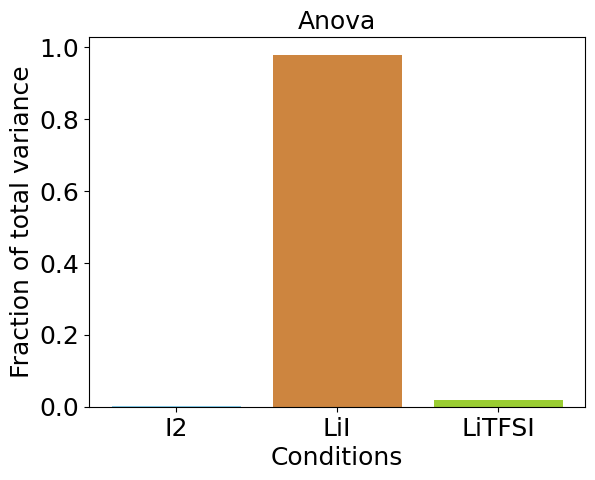

In [7]:
anova(names, 'PCE')

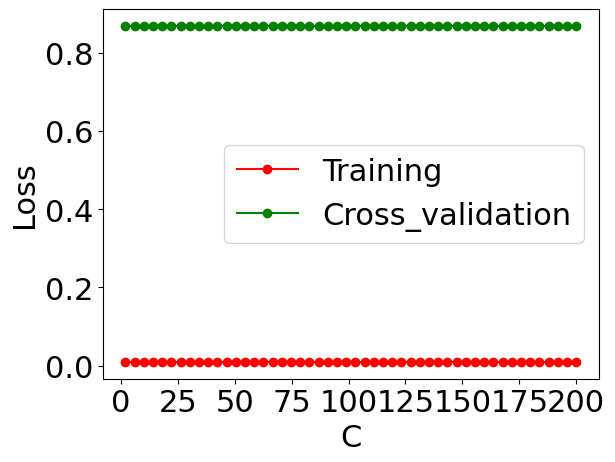

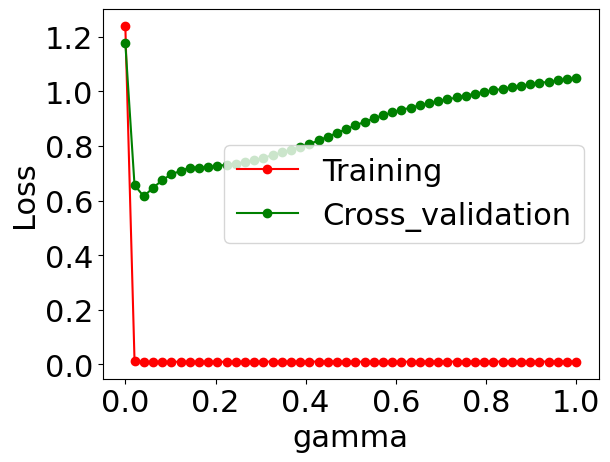

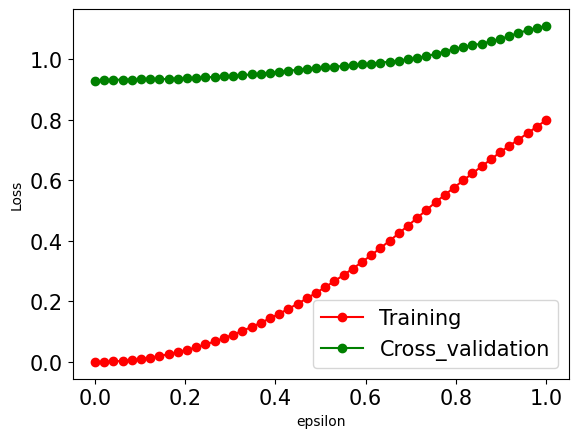

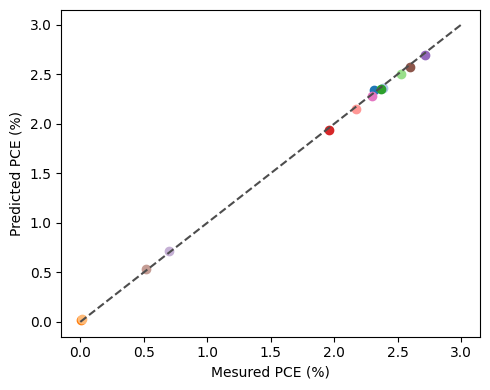

R2 = 0.9998636608860885
C= 100
gamma= 0.6154188874815903
epsilon= 0.02040816326530612


In [8]:
names = ['I2', 'LiI', 'LiTFSI']
reg_pce=pred_fit('PCE', [0,3])

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


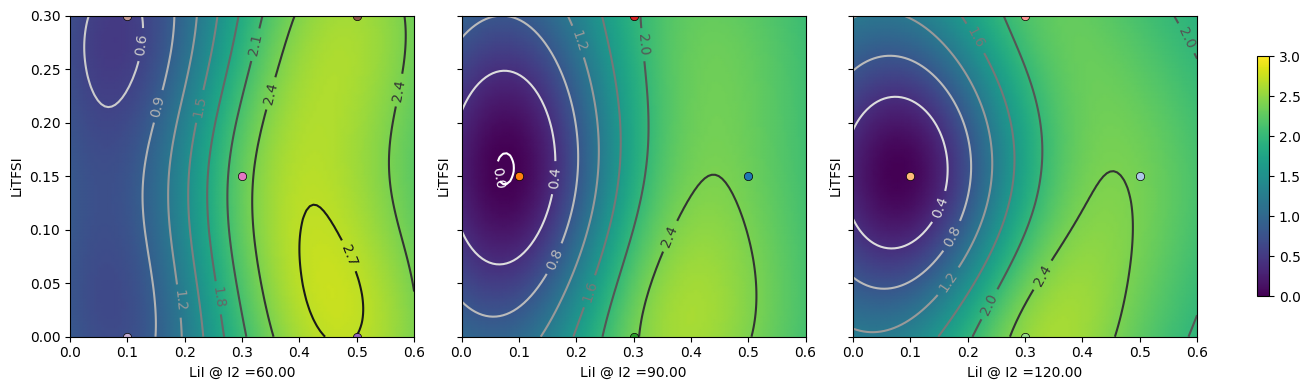

In [9]:
data_v=[60, 90, 120]
surface_plot(reg_pce, 0, 0.6, 0, 0.3, 0, 3, 'viridis')

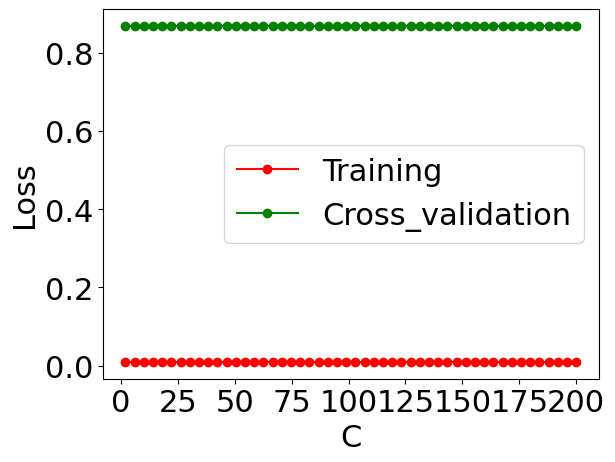

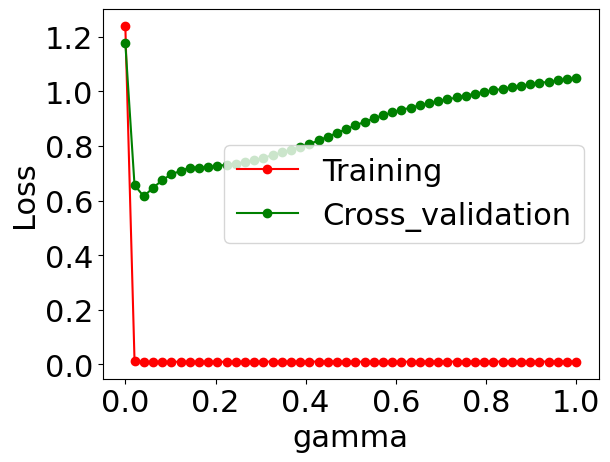

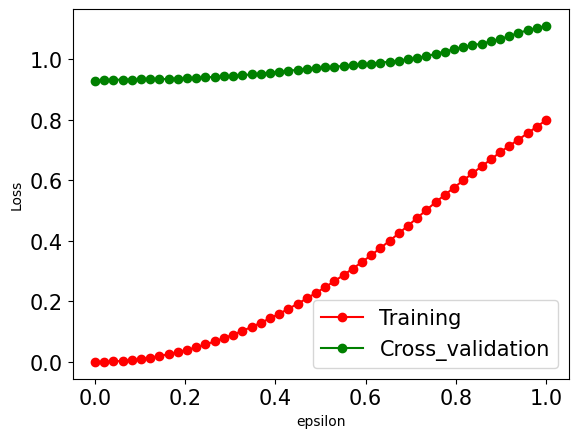

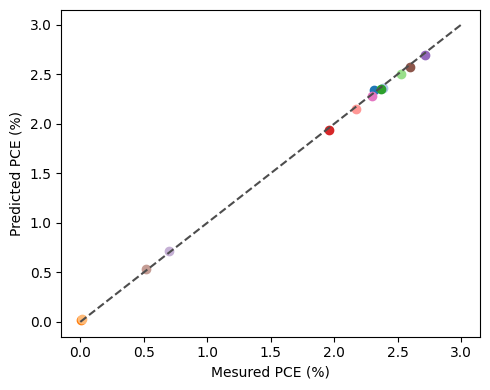

R2 = 0.9998636608860885
C= 100
gamma= 0.6154188874815911
epsilon= 0.02040816326530612


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


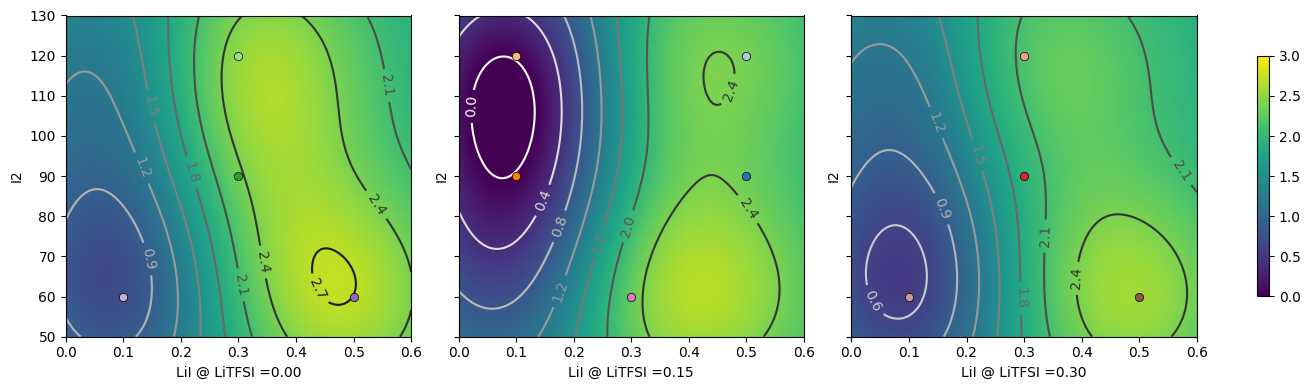

In [10]:
names=['LiTFSI','LiI','I2']
reg_pce=pred_fit('PCE', [0,3])
data_v=[0, 0.15, 0.3]
surface_plot(reg_pce, 0, 0.6, 50, 130, 0, 3, 'viridis')

AVT ~ + C(I2) + C(LiI) + C(LiTFSI)
            df      sum_sq     mean_sq         F    PR(>F)
C(I2)      2.0  133.914939   66.957470  2.437652  0.167931
C(LiI)     2.0  236.275135  118.137568  4.300913  0.069380
C(LiTFSI)  2.0   42.833770   21.416885  0.779703  0.500024
Residual   6.0  164.808125   27.468021       NaN       NaN
[0.32423052833711674, 0.5720617311990562, 0.1037077404638271]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


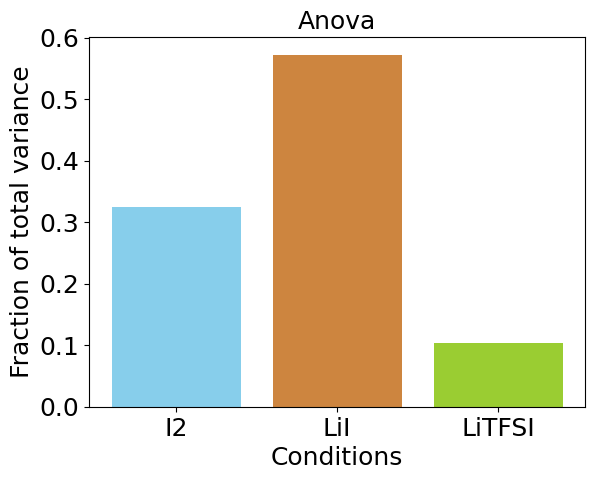

In [13]:
anova(names, 'AVT')

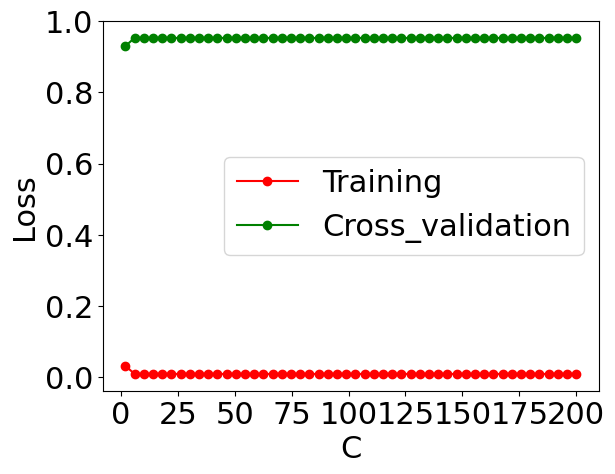

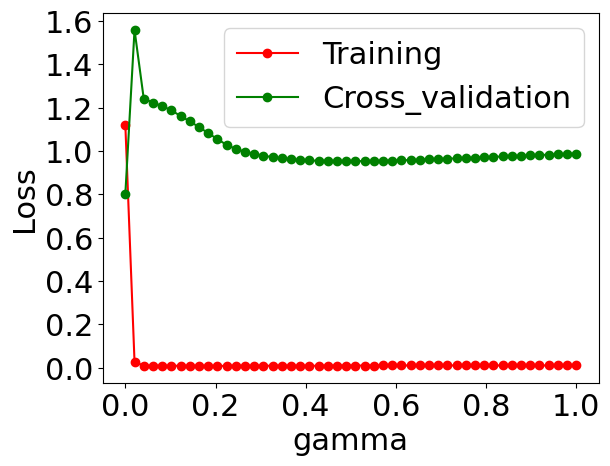

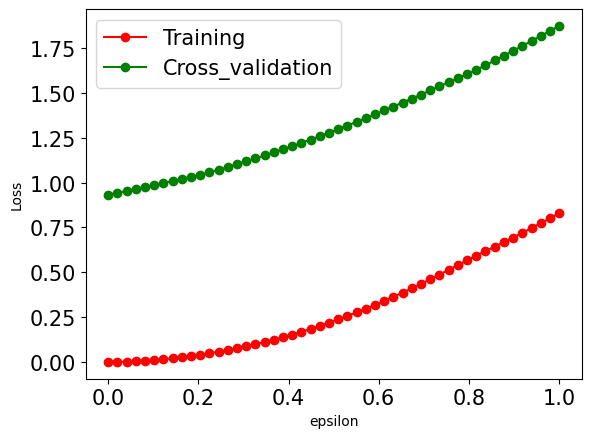

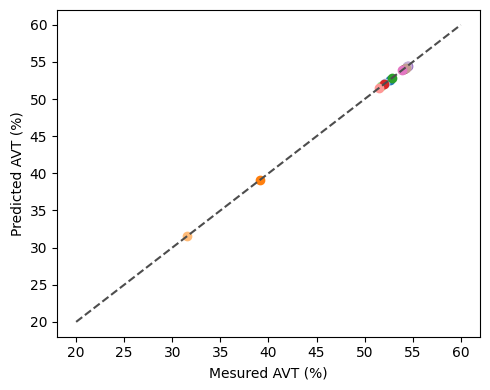

R2 = 0.9999996359872511
C= 100
gamma= 0.9531925565589802
epsilon= 0.02040816326530612


In [14]:
names=['LiTFSI','LiI','I2']
reg_avt=pred_fit('AVT', [20,60])

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


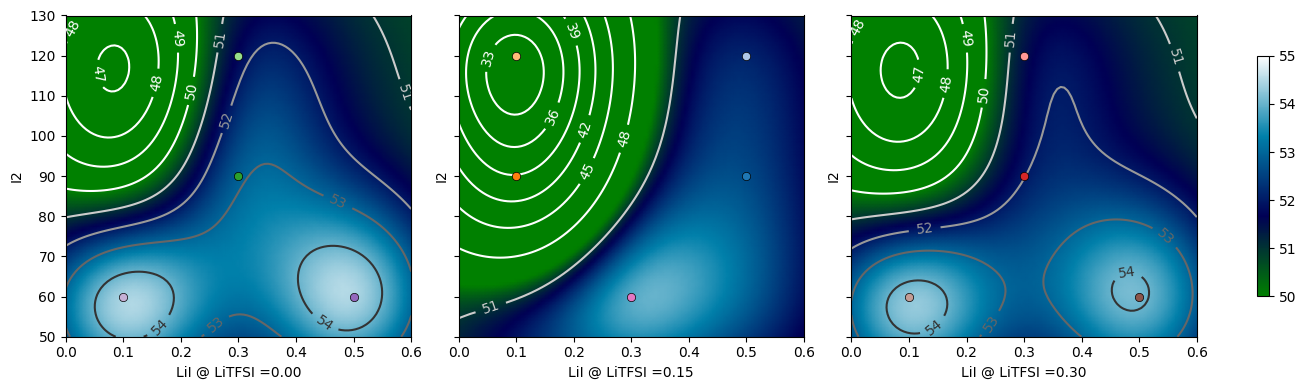

In [15]:
data_v=[0, 0.15, 0.3]
surface_plot(reg_avt, 0, 0.6, 50, 130, 50, 55, 'ocean')

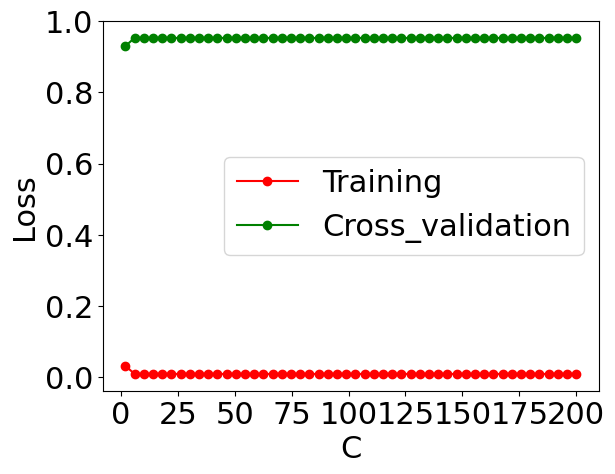

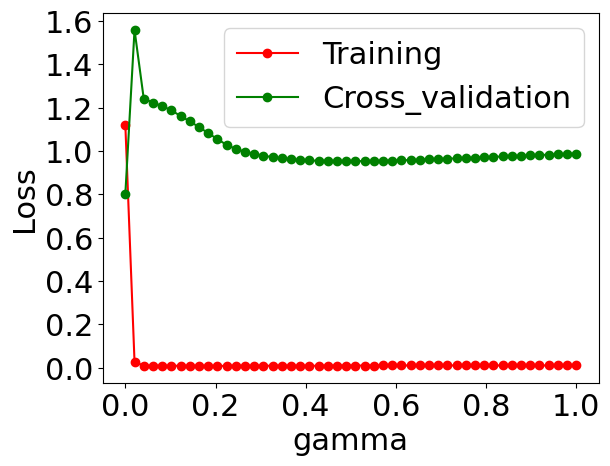

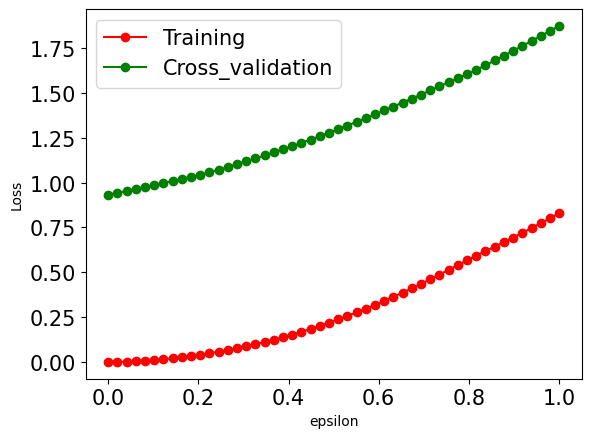

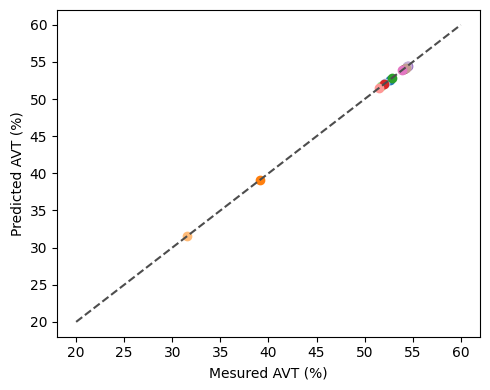

R2 = 0.9999996359872511
C= 100
gamma= 0.9531925565589802
epsilon= 0.02040816326530612


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


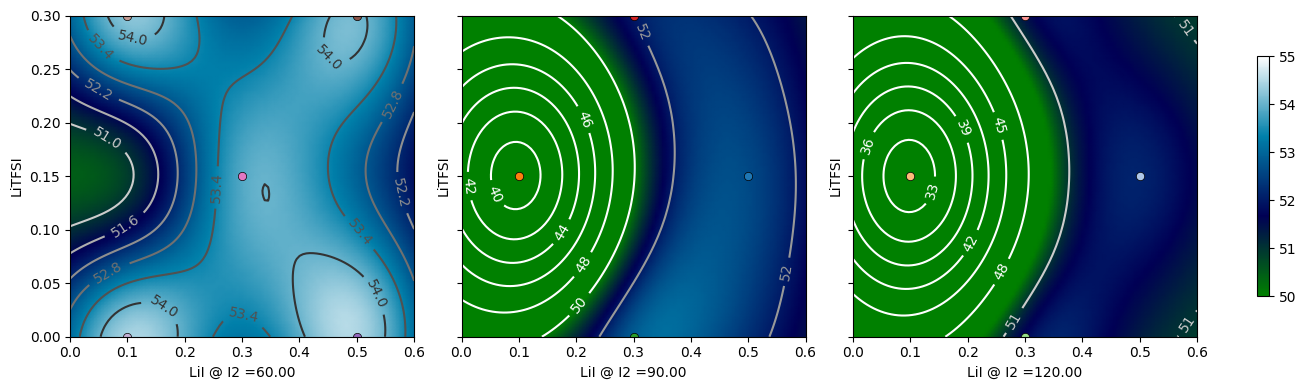

In [16]:
names = ['I2', 'LiI', 'LiTFSI']
reg_avt=pred_fit('AVT', [20,60])
data_v=[60, 90, 120]
surface_plot(reg_avt, 0, 0.6, 0, 0.3, 50, 55, 'ocean')

LUE ~ + C(I2) + C(LiI) + C(LiTFSI)
            df      sum_sq    mean_sq           F        PR(>F)
C(I2)      2.0    0.601984   0.300992    2.644305  1.501524e-01
C(LiI)     2.0  134.538946  67.269473  590.982392  1.288377e-07
C(LiTFSI)  2.0    2.706708   1.353354   11.889620  8.179239e-03
Residual   6.0    0.682959   0.113827         NaN           NaN
[0.004367025230255701, 0.9759974671208195, 0.019635507648924844]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_5140\855282072.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


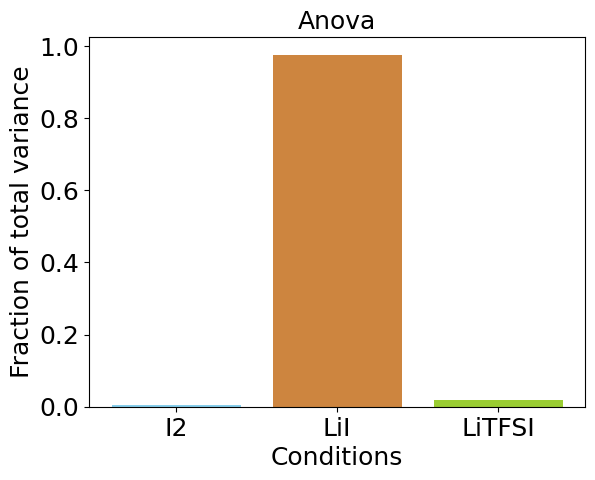

In [17]:
anova(names, 'LUE')

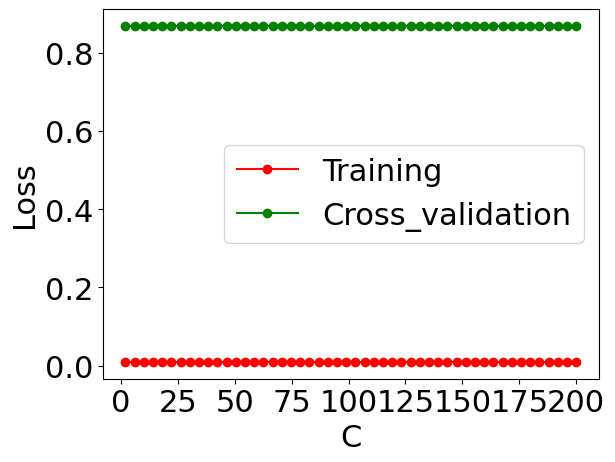

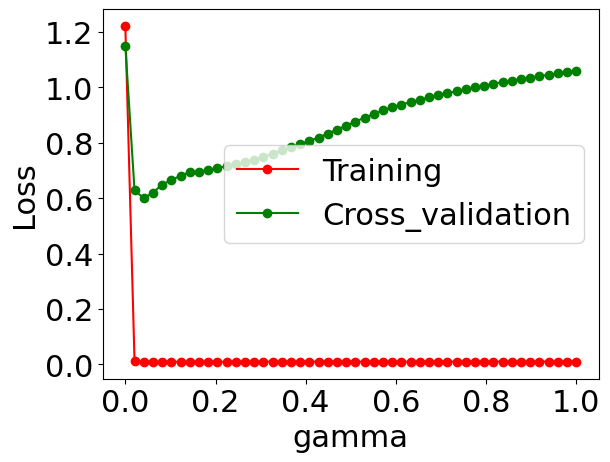

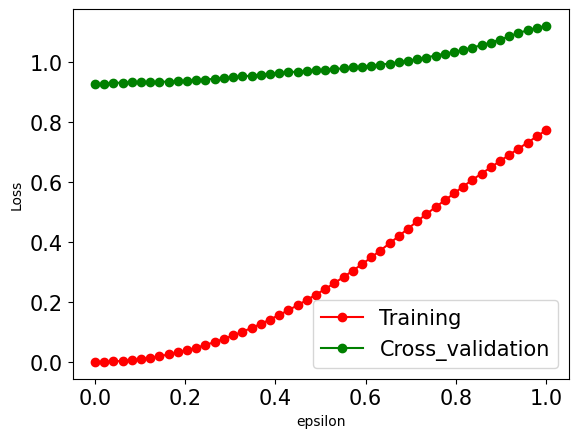

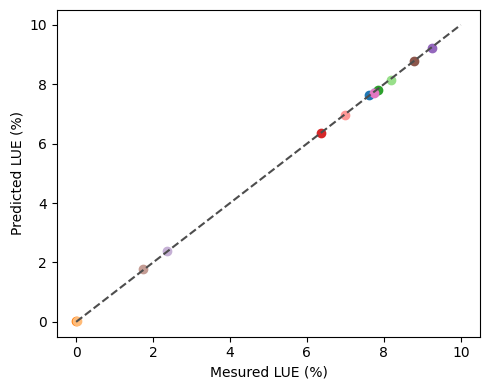

R2 = 0.9999879357702887
C= 100
gamma= 0.5997455476967606
epsilon= 0.02040816326530612


In [18]:
names = ['I2', 'LiI', 'LiTFSI']
reg_lue=pred_fit('LUE', [0,10])

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


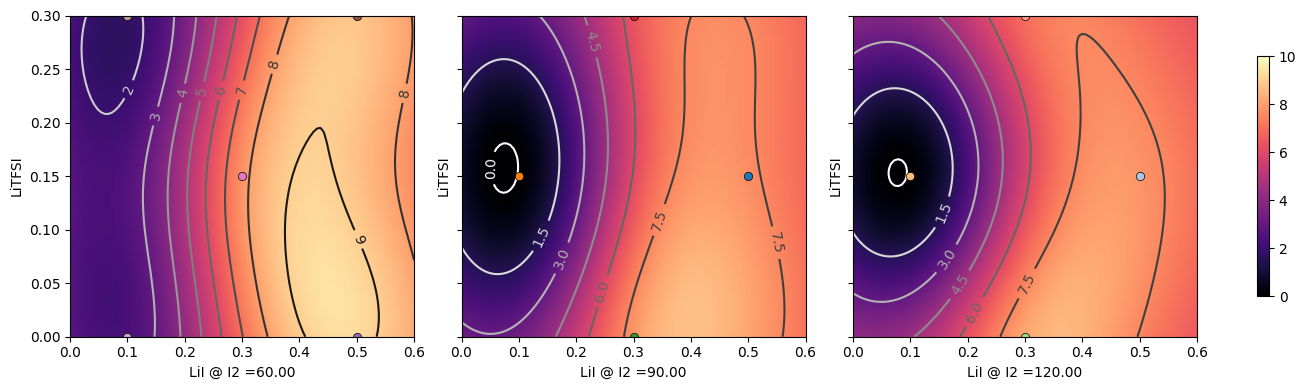

In [19]:
data_v=[60, 90, 120]
surface_plot(reg_lue, 0, 0.6, 0, 0.3, 0, 10, 'magma')

In [9]:
df = pd.read_csv("Iode-2.csv", sep=';') #tableau bien en .CSV dans le même dossier que le programme !
##suppression des NaN: si une fois affiché df comporte des cases NaN, la première ligme ci dessous permet de
#supprimer les lignes ayant moins de 'x' valeurs non NaN (à changer en fonction du tableau obtenu) 
#et la 2 supprime les colonnes comportant au moins un NaN.
#df = df.dropna(thresh=7)
#df= df.dropna(axis='columns')#suppression des NaN
colors = plt.cm.tab20(np.linspace(0, 1, 20)[0:len(df.exp.unique())])
color_dic = {label: color for label, color in zip(df.exp.unique(), colors)}
df['color'] = df.exp.map(color_dic) #ajoute une colonne 'color' à df pour donner une couleur unique à chaque expériences

names = ['I2', 'LiI', 'LiTFSI'] #utiliser ici le nom des colonnes exact de df

df

exp   I2   LiI  LiTFSI       PCE       Voc        Jsc    AVT  AVTafter  \
0     1   90  0.50    0.15  2.317944  0.462903   9.689189  52.64        16   
1     2  120  0.50    0.15  2.385929  0.364763  12.068989  52.13        16   
2     3   90  0.10    0.15  0.002208  0.584890   0.215903  39.12        16   
3     4  120  0.10    0.15  0.010700  0.223680   0.498322  31.50        16   
4     5   90  0.30    0.00  2.372845  0.457603  10.650008  52.89        16   
5     6  120  0.30    0.00  2.528434  0.459231  11.152592  51.75        16   
6     7   90  0.30    0.30  1.959585  0.441127   9.315339  52.00        16   
7     8  120  0.30    0.30  2.173696  0.442424   9.560931  51.47        16   
8     9   60  0.50    0.00  2.718247  0.429798  12.979069  54.48        16   
9    10   60  0.10    0.00  0.696832  0.506554   2.626947  54.44        16   
10   11   60  0.50    0.30  2.599122  0.427150  12.161258  54.10        16   
11   12   60  0.10    0.30  0.516424  0.453797   2.013053  54.26        16   
12   13   60  0.30    0.15  2.298583  0.440607  10.743356  53.88        16   
13   14   60  0.40    0.00  2.705830  0.426302  13.454075  54.32        16   
14   15   60  0.45    0.05  2.720180  0.410821  13.991469  53.51        16   
15   16   60  0.40    0.10  2.699462  0.407157  14.392694  53.05        16   
16   17   60  0.50    0.10  2.656776  0.406640  14.507764  53.72        16   

          Coc       LUE                                              color  
0        3.29  7.626036  [0.12156862745098039, 0.4666666666666667, 0.70...  
1   3.258.125  7.773655  [0.6823529411764706, 0.7803921568627451, 0.909...  
2       2.445  0.005399  [1.0, 0.4980392156862745, 0.054901960784313725...  
3     196.875  0.021066  [1.0, 0.7333333333333333, 0.47058823529411764,...  
4   3.305.625  7.843736  [0.17254901960784313, 0.6274509803921569, 0.17...  
5   3.234.375  8.177904  [0.596078431372549, 0.8745098039215686, 0.5411...  
6        3.25  6.368651  [0.8392156862745098, 0.15294117647058825, 0.15...  
7   3.216.875  6.992508  [1.0, 0.596078431372549, 0.5882352941176471, 1.0]  
8       3.405  9.255631  [0.5803921568627451, 0.403921568627451, 0.7411...  
9      34.025  2.370971  [0.7725490196078432, 0.6901960784313725, 0.835...  
10    338.125  8.788281  [0.5490196078431373, 0.33725490196078434, 0.29...  
11    339.125  1.751323  [0.7686274509803922, 0.611764705882353, 0.5803...  
12     33.675  7.740478  [0.8901960784313725, 0.4666666666666667, 0.760...  
13          1  9.862929  [0.9686274509803922, 0.7137254901960784, 0.823...  
14          1  9.097302  [0.4980392156862745, 0.4980392156862745, 0.498...  
15          1  8.950404  [0.7803921568627451, 0.7803921568627451, 0.780...  
16          1  8.920125  [0.7372549019607844, 0.7411764705882353, 0.133...

AVT ~ + C(I2) + C(LiI) + C(LiTFSI)
            df      sum_sq    mean_sq         F    PR(>F)
C(I2)      2.0  166.302203  83.151101  3.445477  0.090841
C(LiI)     4.0  227.257633  56.814408  2.354181  0.152252
C(LiTFSI)  4.0   59.365674  14.841419  0.614974  0.665735
Residual   7.0  168.933839  24.133406       NaN       NaN
[0.3671734074032213, 0.5017549864863011, 0.13107160611047755]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


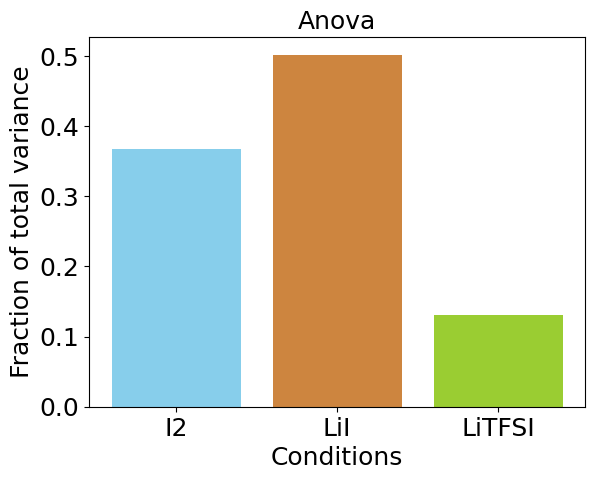

In [10]:
anova(names, 'AVT')

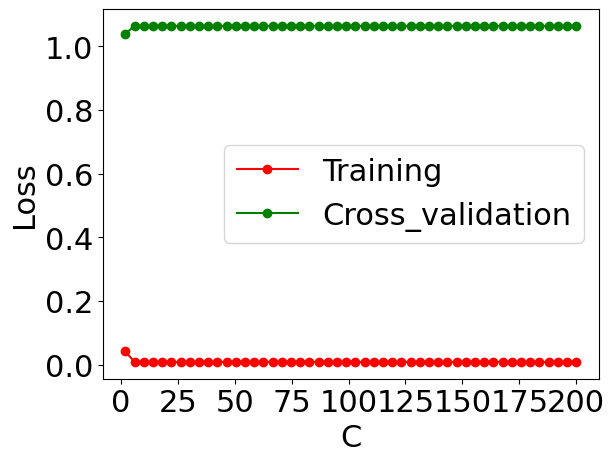

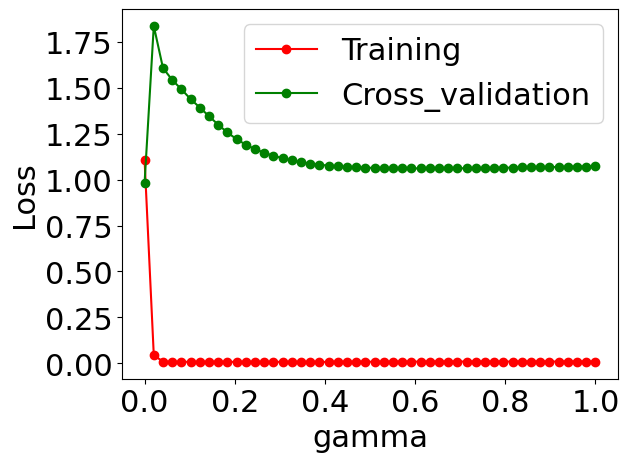

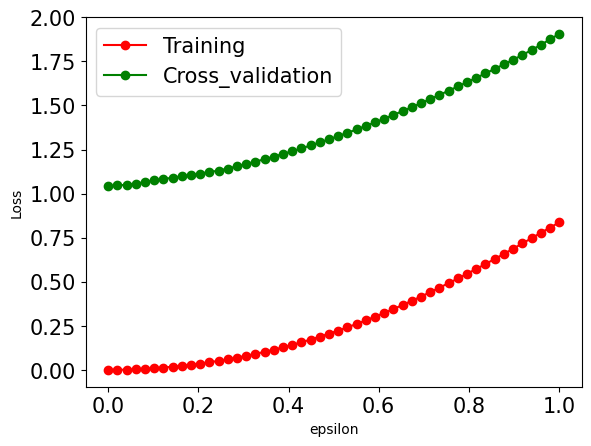

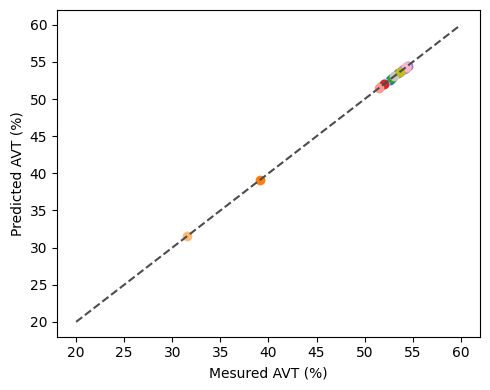

R2 = 0.9999950058951375
C= 100
gamma= 1.0607245334605644
epsilon= 0.02040816326530612


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


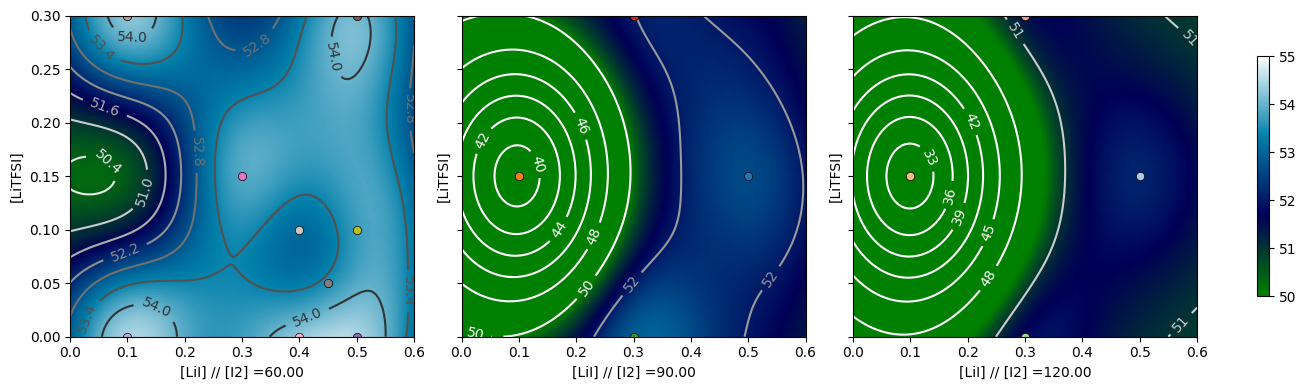

In [54]:
names = ['I2', 'LiI', 'LiTFSI']
reg_avt=pred_fit('AVT', [20,60])
data_v=[60, 90, 120]
surface_plot(reg_avt, 0, 0.6, 0, 0.3, 50, 55, 'ocean')

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


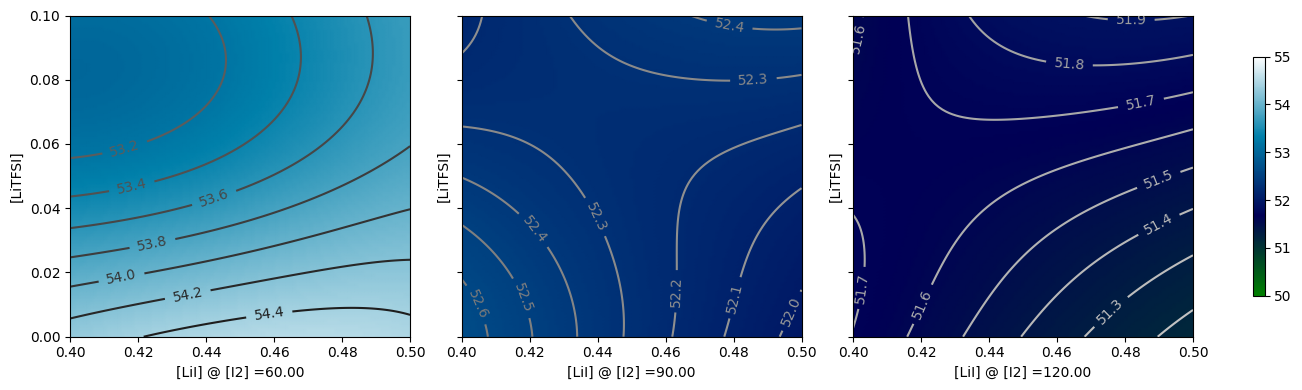

In [55]:
data_v=[60,90,120]
surface_plot2(reg_avt, 0.4, 0.5, 0, 0.1, 50, 55, 'ocean')

PCE ~ + C(I2) + C(LiI) + C(LiTFSI)
            df     sum_sq   mean_sq           F        PR(>F)
C(I2)      2.0   0.921591  0.460795   33.737909  2.545597e-04
C(LiI)     4.0  14.179490  3.544873  259.543756  1.100591e-07
C(LiTFSI)  4.0   0.229177  0.057294    4.194897  4.801982e-02
Residual   7.0   0.095607  0.013658         NaN           NaN
[0.06011581317977751, 0.9249348530111714, 0.014949333809051004]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


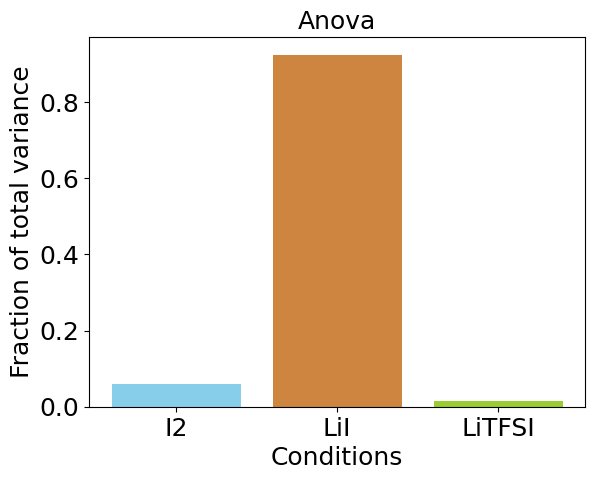

In [11]:
anova(names, 'PCE')

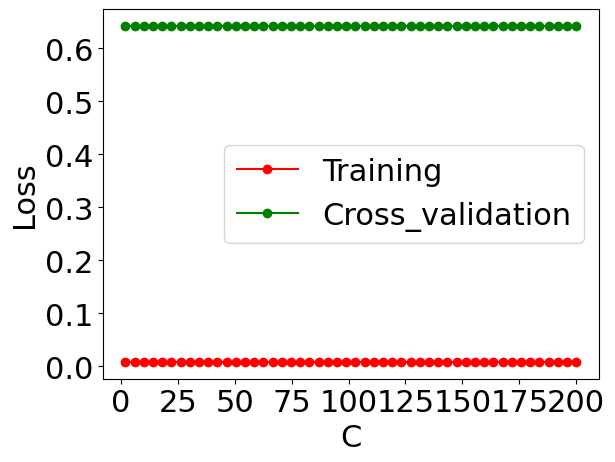

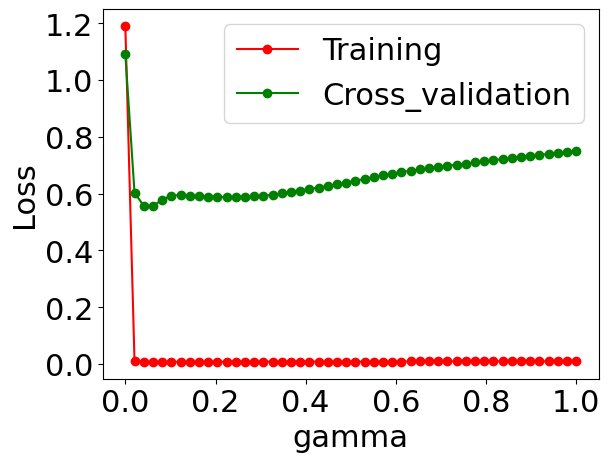

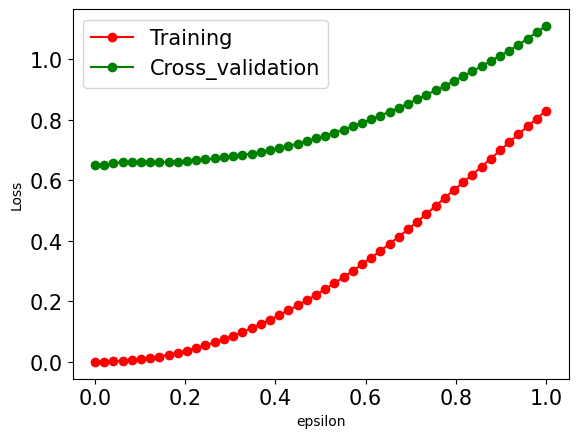

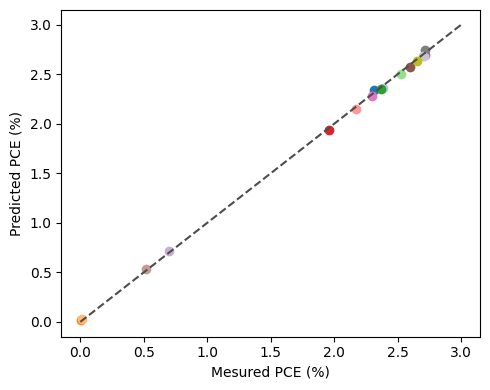

R2 = 0.9997863343347811
C= 100
gamma= 0.5556183005385213
epsilon= 0.02040816326530612


In [56]:
names = ['I2', 'LiI', 'LiTFSI']
reg_pce=pred_fit('PCE', [0,3])

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


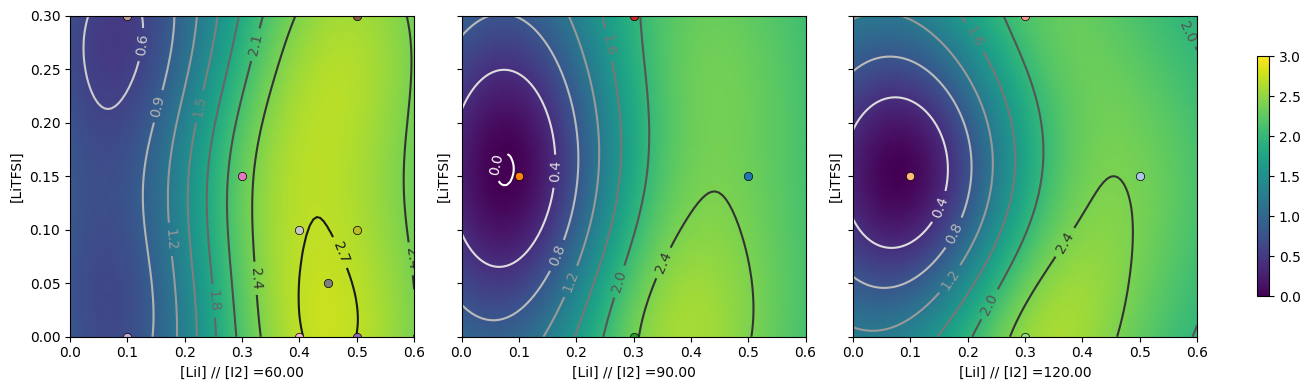

In [57]:
data_v=[60, 90, 120]
surface_plot(reg_pce, 0, 0.6, 0, 0.3, 0, 3, 'viridis')

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


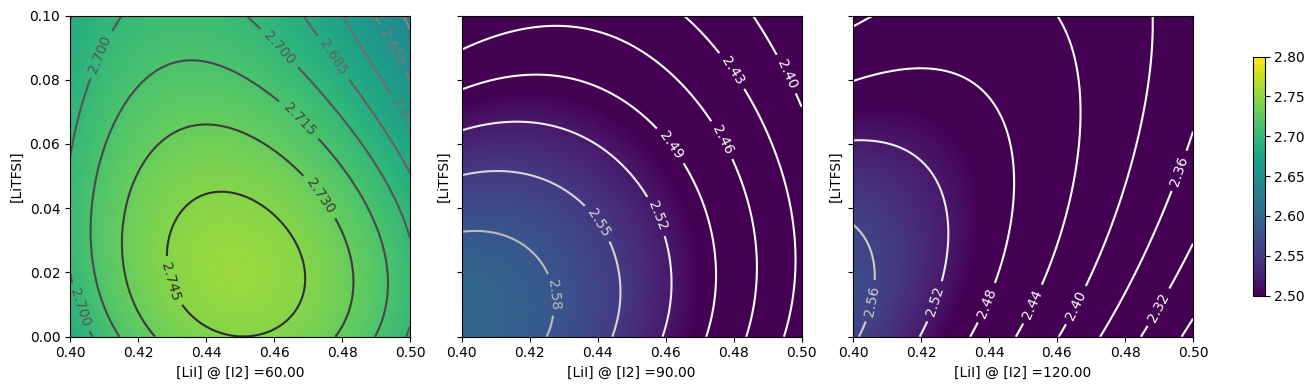

In [58]:
data_v=[60, 90, 120]
surface_plot2(reg_pce, 0.4, 0.5, 0, 0.1, 2.5, 2.8, 'viridis')

LUE ~ + C(I2) + C(LiI) + C(LiTFSI)
            df      sum_sq    mean_sq           F        PR(>F)
C(I2)      2.0   14.096150   7.048075   71.466212  2.198916e-05
C(LiI)     4.0  157.837593  39.459398  400.111207  2.444027e-08
C(LiTFSI)  4.0    3.125960   0.781490    7.924168  9.735207e-03
Residual   7.0    0.690348   0.098621         NaN           NaN
[0.08052195607187483, 0.9016215085684273, 0.017856535359697966]


C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  totalSSRnoRes = sum(res.sum_sq)-res.sum_sq[-1]  # for normalizing
C:\Users\Johan Liotier\AppData\Local\Temp\ipykernel_11912\347748843.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  performance+=[res.sum_sq[i]/totalSSRnoRes]


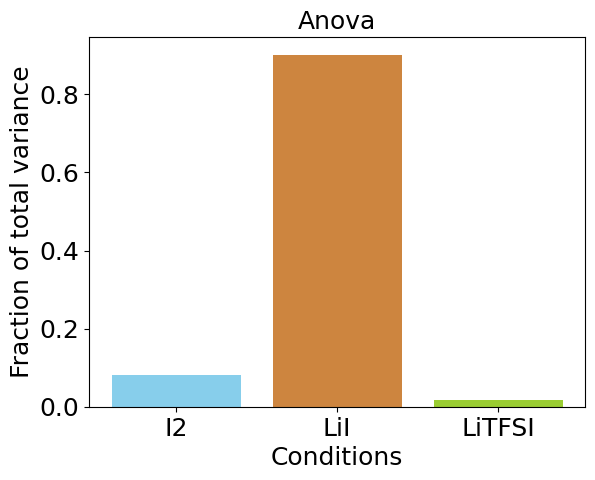

In [12]:
anova(names, 'LUE')

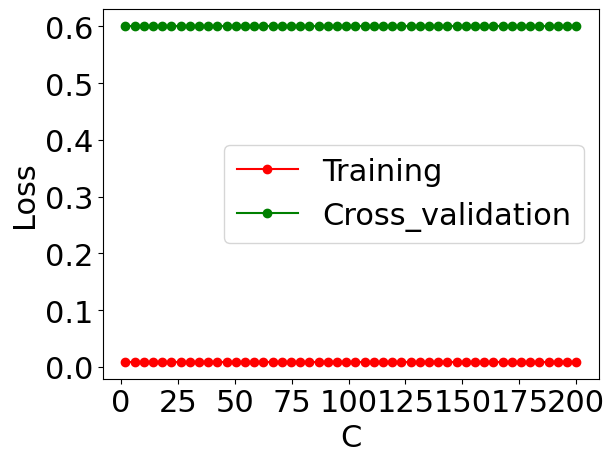

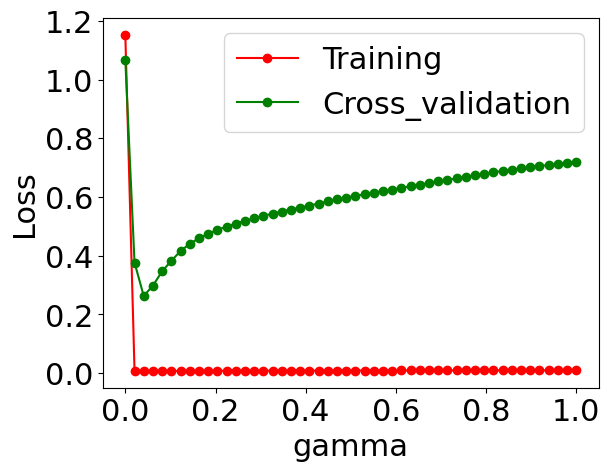

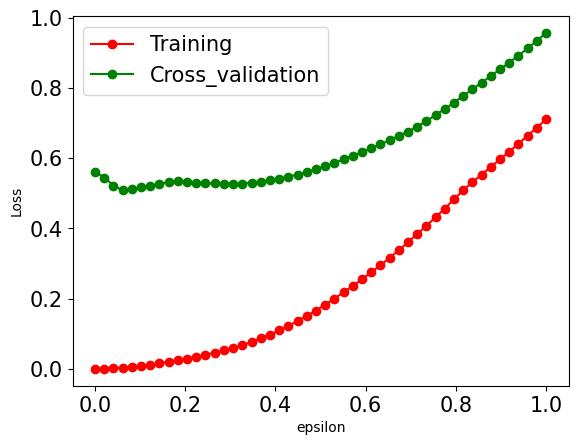

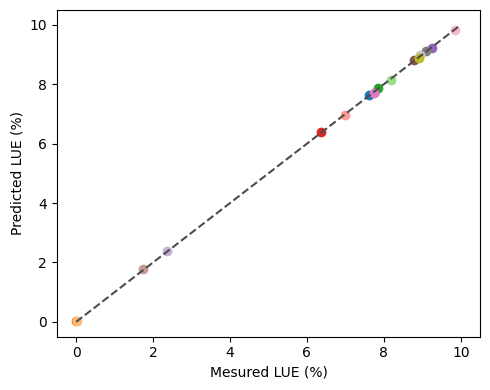

R2 = 0.9999692896339665
C= 100
gamma= 0.26288240591126966
epsilon= 0.02040816326530612


In [13]:
names = ['I2', 'LiI', 'LiTFSI']
reg_lue=pred_fit('LUE', [0,10])

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


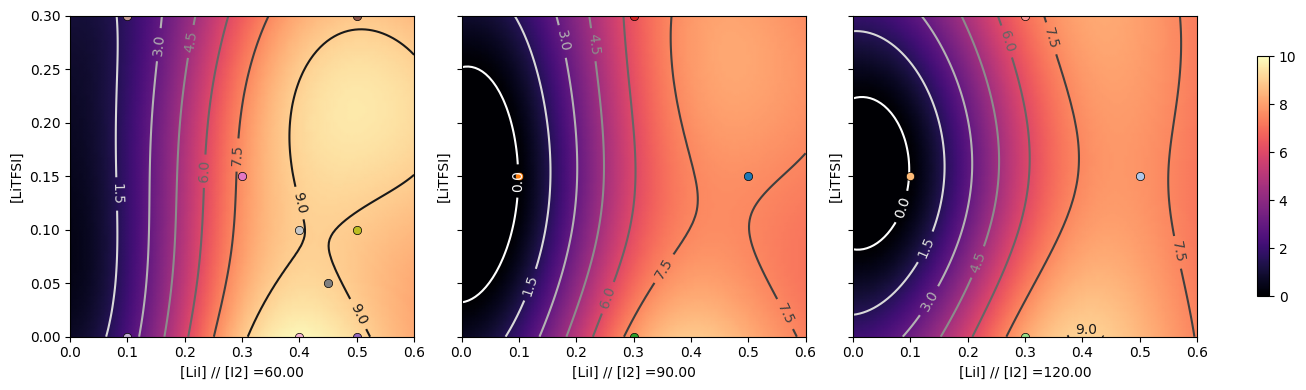

In [51]:
data_v=[60, 90, 120]
surface_plot(reg_lue, 0, 0.6, 0, 0.3, 0, 10, 'magma')

C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Johan Liotier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


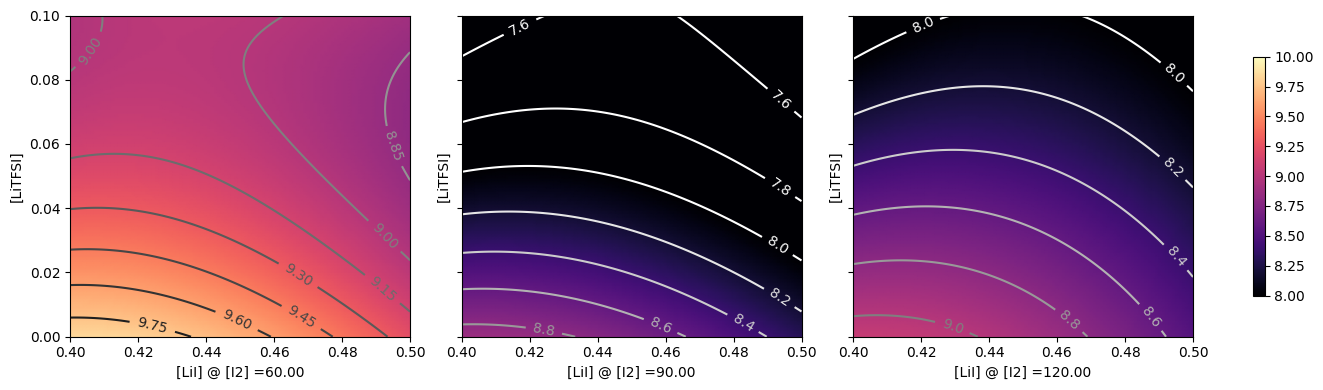

In [53]:
data_v=[60, 90, 120]
surface_plot2(reg_lue, 0.4, 0.5, 0, 0.1, 8, 10, 'magma')